In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.interpolate import interp1d
from scipy.special import spherical_jn
from tqdm import tqdm

import mu2

from interaction import LocalSystem, potential
import constants as const
import utility
import bind

plt.style.use('science')
gr = 4/3
h = 3

In [2]:
const.BETA4

32.70989286766126

In [3]:
def alpha(r):
    return 9/2 - 2/3*np.exp(-2*r) * (r**5 + 9/2*r**4 + 9*r**3 + 27/2*r**2 + 27/2*r + 27/4)


def mm_potential(r):
    return -1/2 * alpha(r) / r**4

In [4]:
# Compute the Mott-Massey results
mm = LocalSystem(1.5, nq=300)
vtilde_mm = utility.ft_matrix_gen(mm_potential, 0, 0, mm.q, mm.r_nodes, mm.r_weights)

In [5]:
KCD_0_MM = mu2.cc.cscatter.kcotdelta_py(0, vtilde_mm, mm.q, mm.wq, 10*2/1.5, 0, 2*const.MU)
KCD_0_MM

0.016387141028324854

In [6]:
-1/KCD_0_MM

-61.023457250506326

In [7]:
Rs = const.BETA4/np.linspace(10, 40, 50)

In [8]:
Ri = Rs[0]
ls = LocalSystem(Ri, nq=200)

In [9]:
def kcd0(g, ls):
    return mu2.cc.cscatter.kcotdelta_py(
        0, ls.v_tilde + ls.counterterm.gen(guess, 0), ls.q, ls.wq, 10*2/Ri, 0, 2*const.MU
    )

In [10]:
guess = -0.05
kcd0(guess, ls), ls.bound_state_spectrum(guess, 0).size

(0.02249470520250561, 7)

In [13]:
def froot(g, ls, qmax):
    spectrum = ls.bound_state_spectrum(g, 0)
    assert spectrum.size == 7, f'There are {spectrum.size} bounds states.'
    return (KCD_0_MM - mu2.cc.cscatter.kcotdelta_py(
        0, ls.v_tilde + ls.counterterm.gen(g, 0), ls.q, ls.wq, qmax, 0, 2*const.MU)) / KCD_0_MM

In [15]:
guess = -0.050715
froot(guess, ls, 10*2/Ri)

0.018321834518048277

In [16]:
class Data:
    def __init__(self, ls, g_lo, qmax):
        self.a0 = -1/mu2.cc.cscatter.kcotdelta_py(
            0, ls.v_tilde + ls.counterterm.gen(g_lo, 0), ls.q, ls.wq, qmax, 0, 2*const.MU)
        evals, evecs = bind.bound_states(ls.v_tilde, ls.counterterm.gen(g_lo, 0), 1, ls.q, ls.wq)
        self.lo_evals = np.copy(evals)
        self.lo_evecs = np.copy(evecs)
        self.R = ls.r_c
        self.g_lo = g_lo

In [18]:
nq = 400
glos = np.zeros(Rs.size)
data = []
for (i, Ri) in enumerate(Rs):
    qmax = 40*2/Ri
    qmesh = utility.log_mesh(0, qmax, nq)
    ls = LocalSystem(Ri, qmesh=qmesh)
    result = optimize.fsolve(froot, guess, args=(ls, qmax), xtol=1e-12)
    glo = result[0]
    
    glos[i] = glo
    data.append(Data(ls, glo, qmax))
    
    if i < 5:
        guess = glo
    else:
        curve = interp1d(Rs[i-5:i], glos[i-5:i], kind='cubic', fill_value='extrapolate')
        try:
            guess = curve(Rs[i+1])
        except:
            break
    
    print(f'i = {i}  R = {Ri:.4e}  g_LO = {glo:.4e}')

i = 0  R = 3.2710e+00  g_LO = -5.0667e-02
i = 1  R = 3.0823e+00  g_LO = -5.3953e-02
i = 2  R = 2.9142e+00  g_LO = -5.6584e-02
i = 3  R = 2.7634e+00  g_LO = -5.8493e-02
i = 4  R = 2.6275e+00  g_LO = -5.9887e-02
i = 5  R = 2.5044e+00  g_LO = -6.0955e-02
i = 6  R = 2.3922e+00  g_LO = -6.1662e-02
i = 7  R = 2.2897e+00  g_LO = -6.1845e-02
i = 8  R = 2.1956e+00  g_LO = -6.1363e-02
i = 9  R = 2.1089e+00  g_LO = -6.0184e-02
i = 10  R = 2.0288e+00  g_LO = -5.8357e-02
i = 11  R = 1.9546e+00  g_LO = -5.5938e-02
i = 12  R = 1.8856e+00  g_LO = -5.2937e-02
i = 13  R = 1.8213e+00  g_LO = -4.9347e-02
i = 14  R = 1.7613e+00  g_LO = -4.5179e-02
i = 15  R = 1.7051e+00  g_LO = -4.0475e-02
i = 16  R = 1.6524e+00  g_LO = -3.5318e-02
i = 17  R = 1.6028e+00  g_LO = -2.9830e-02
i = 18  R = 1.5561e+00  g_LO = -2.4142e-02
i = 19  R = 1.5121e+00  g_LO = -1.8273e-02
i = 20  R = 1.4704e+00  g_LO = -1.1968e-02
i = 21  R = 1.4311e+00  g_LO = -4.6348e-03
i = 22  R = 1.3937e+00  g_LO = 4.6340e-03
i = 23  R = 1.3583e+00

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


i = 38  R = 9.8330e-01  g_LO = 4.2130e+00
i = 39  R = 9.6553e-01  g_LO = 5.9973e+00
i = 40  R = 9.4839e-01  g_LO = 8.6425e+00
i = 41  R = 9.3185e-01  g_LO = 1.2619e+01
i = 42  R = 9.1588e-01  g_LO = 1.8681e+01
i = 43  R = 9.0044e-01  g_LO = 2.8066e+01
i = 44  R = 8.8552e-01  g_LO = 4.2816e+01
i = 45  R = 8.7108e-01  g_LO = 6.6374e+01
i = 46  R = 8.5710e-01  g_LO = 1.0463e+02
i = 47  R = 8.4357e-01  g_LO = 1.6782e+02
i = 48  R = 8.3046e-01  g_LO = 2.7407e+02


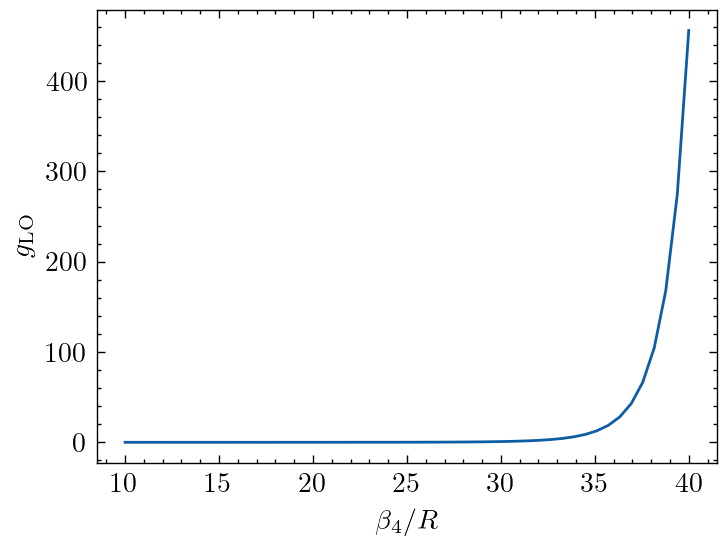

In [19]:
fig, ax = plt.subplots(figsize=(gr*h, h), dpi=200)
fig.patch.set_facecolor('white')

ax.plot(const.BETA4/Rs, glos)

# ax.set_ylim([-1, 1])
ax.set_xlabel(r'$\beta_4/R$')
ax.set_ylabel(r'$g_{\rm LO}$');

In [20]:
lo_specs = np.array([d.lo_evals for d in data])

In [21]:
-1/KCD_0_MM - np.array([d.a0 for d in data])

array([-1.42108547e-14,  1.27897692e-13, -5.25801624e-13,  1.06581410e-13,
        2.06057393e-13,  4.26325641e-13,  9.23705556e-14,  9.23705556e-14,
        6.18172180e-13,  9.23705556e-14,  1.06581410e-13,  0.00000000e+00,
       -7.81597009e-14, -1.77635684e-13, -1.91846539e-13,  6.39488462e-14,
        1.27897692e-13,  0.00000000e+00, -9.23705556e-14,  3.90798505e-13,
        2.98427949e-13, -1.42108547e-13,  0.00000000e+00, -9.94759830e-14,
        2.84217094e-14, -8.10018719e-13,  7.60280727e-13, -3.83693077e-13,
        4.26325641e-14,  9.23705556e-14,  7.81597009e-14,  1.42108547e-13,
       -3.48165941e-13,  7.60280727e-13,  1.70530257e-13,  2.22399876e-12,
       -3.19744231e-13, -3.62376795e-13, -1.42108547e-13,  4.97379915e-14,
       -9.94759830e-13,  1.49924517e-12, -8.88178420e-13, -6.26698693e-12,
       -1.15107923e-12, -1.31237243e-11,  6.32383035e-13,  4.54249971e-11,
       -3.03970182e-11, -6.12487838e-12])

In [22]:
mm_evals, mm_evecs = bind.bound_states(vtilde_mm, 0, 0, mm.q, mm.wq)
mm_evals

array([-0.06476089, -0.04422743, -0.02740697, -0.01466169, -0.00611619,
       -0.00156321, -0.00012021])

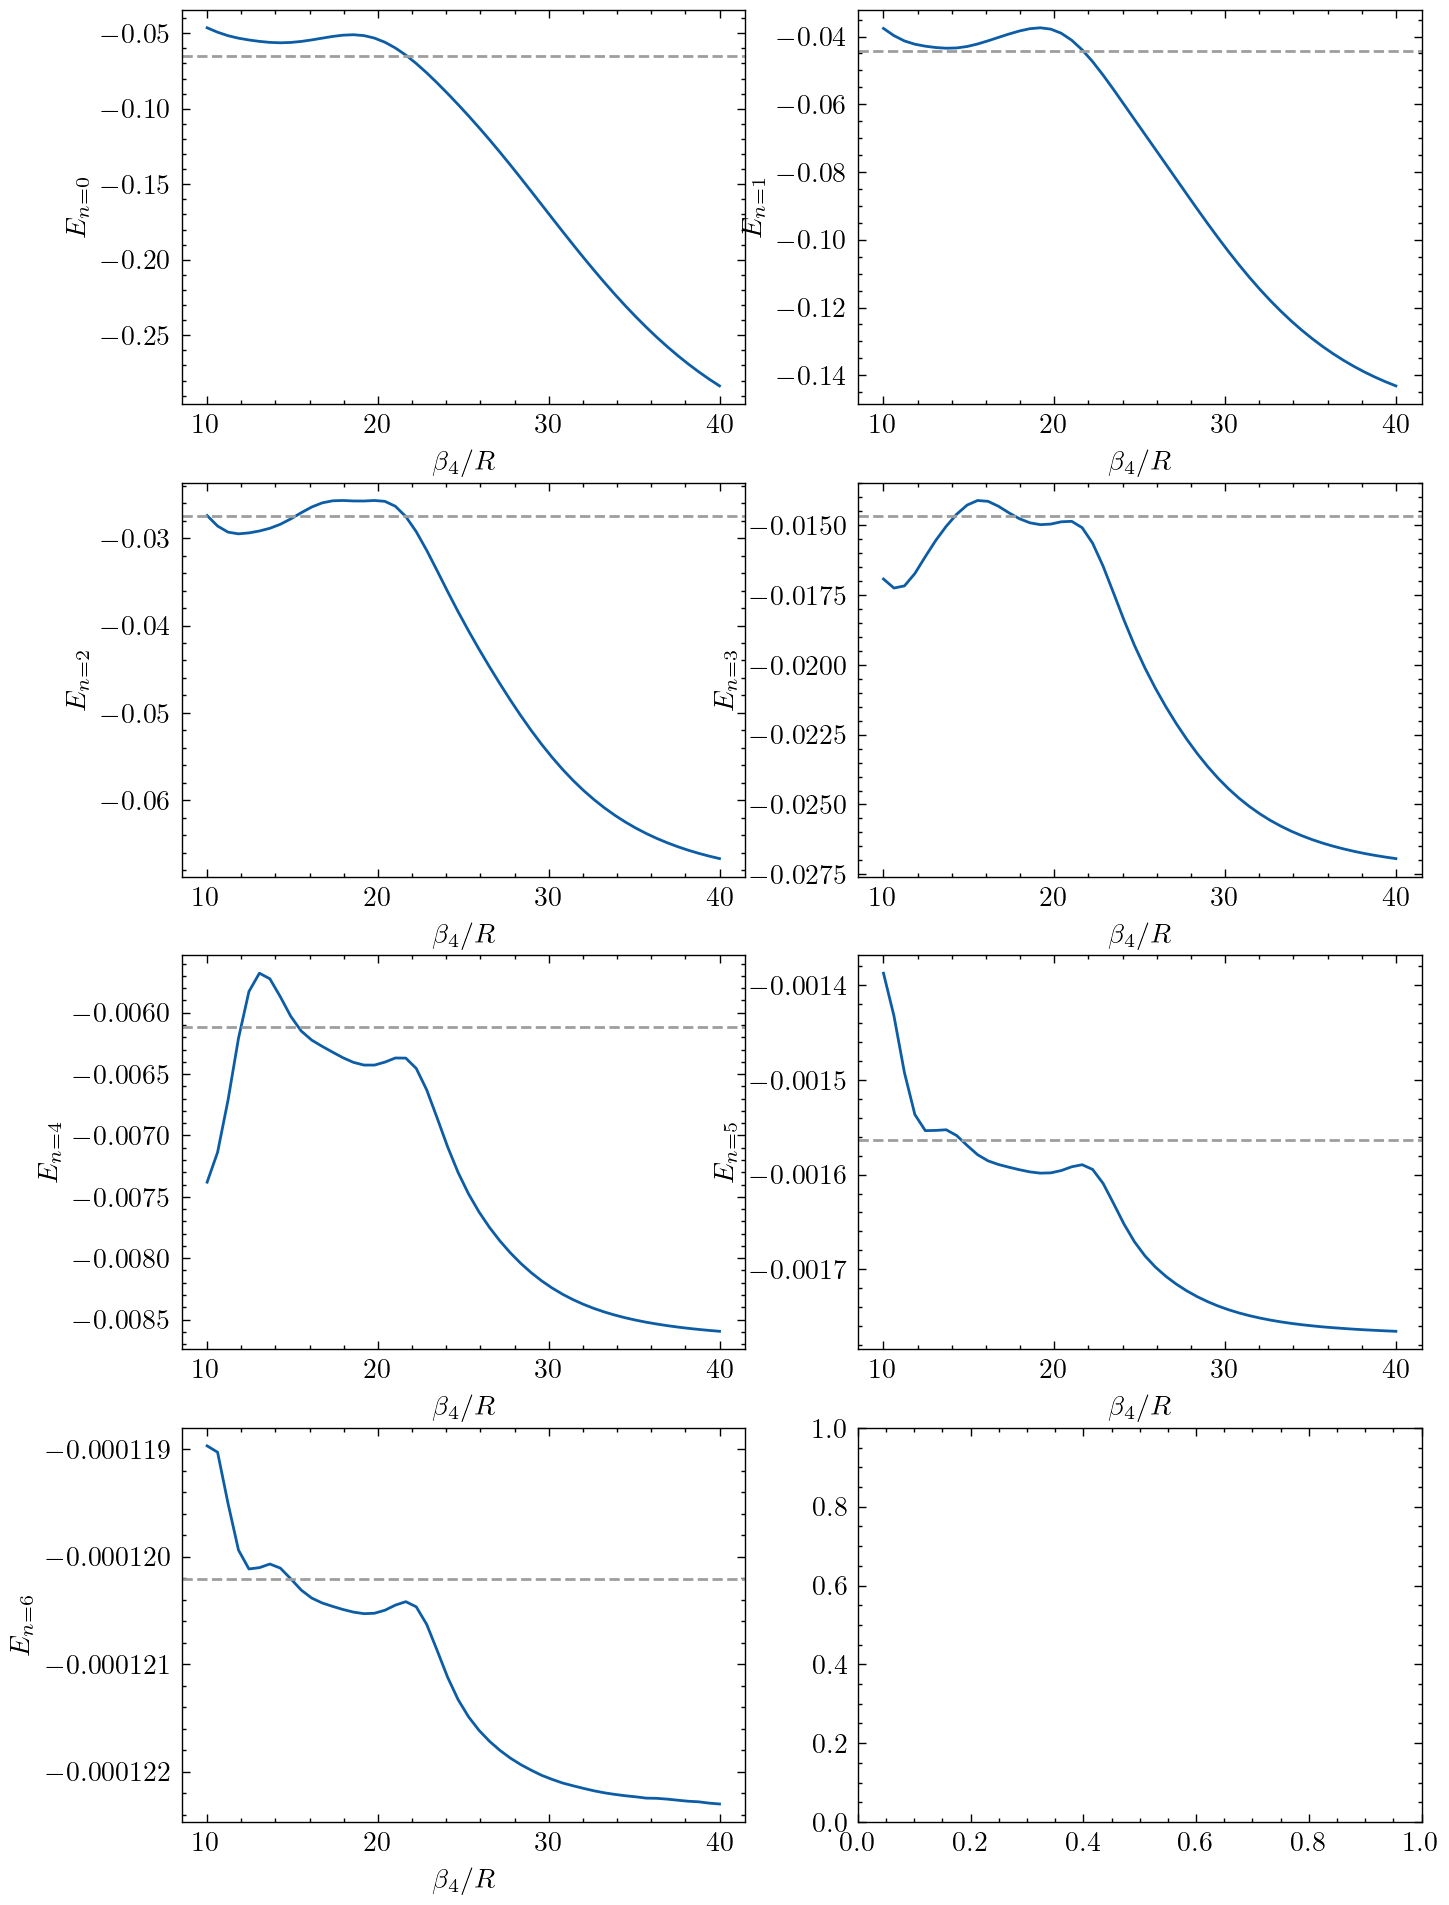

In [23]:
fig, ax = plt.subplots(4, 2, figsize=(2*gr*h, 4*h), dpi=200)
fig.patch.set_facecolor('white')

for i in range(7):
    ax[i//2, i%2].plot(const.BETA4/Rs, lo_specs[:, i])
    ax[i//2, i%2].axhline(mm_evals[i], linestyle='--', color='C6')
    ax[i//2, i%2].set_xlabel(r'$\beta_4/R$')
    ax[i//2, i%2].set_ylabel(r'$E_{n=%d}$' % (i));

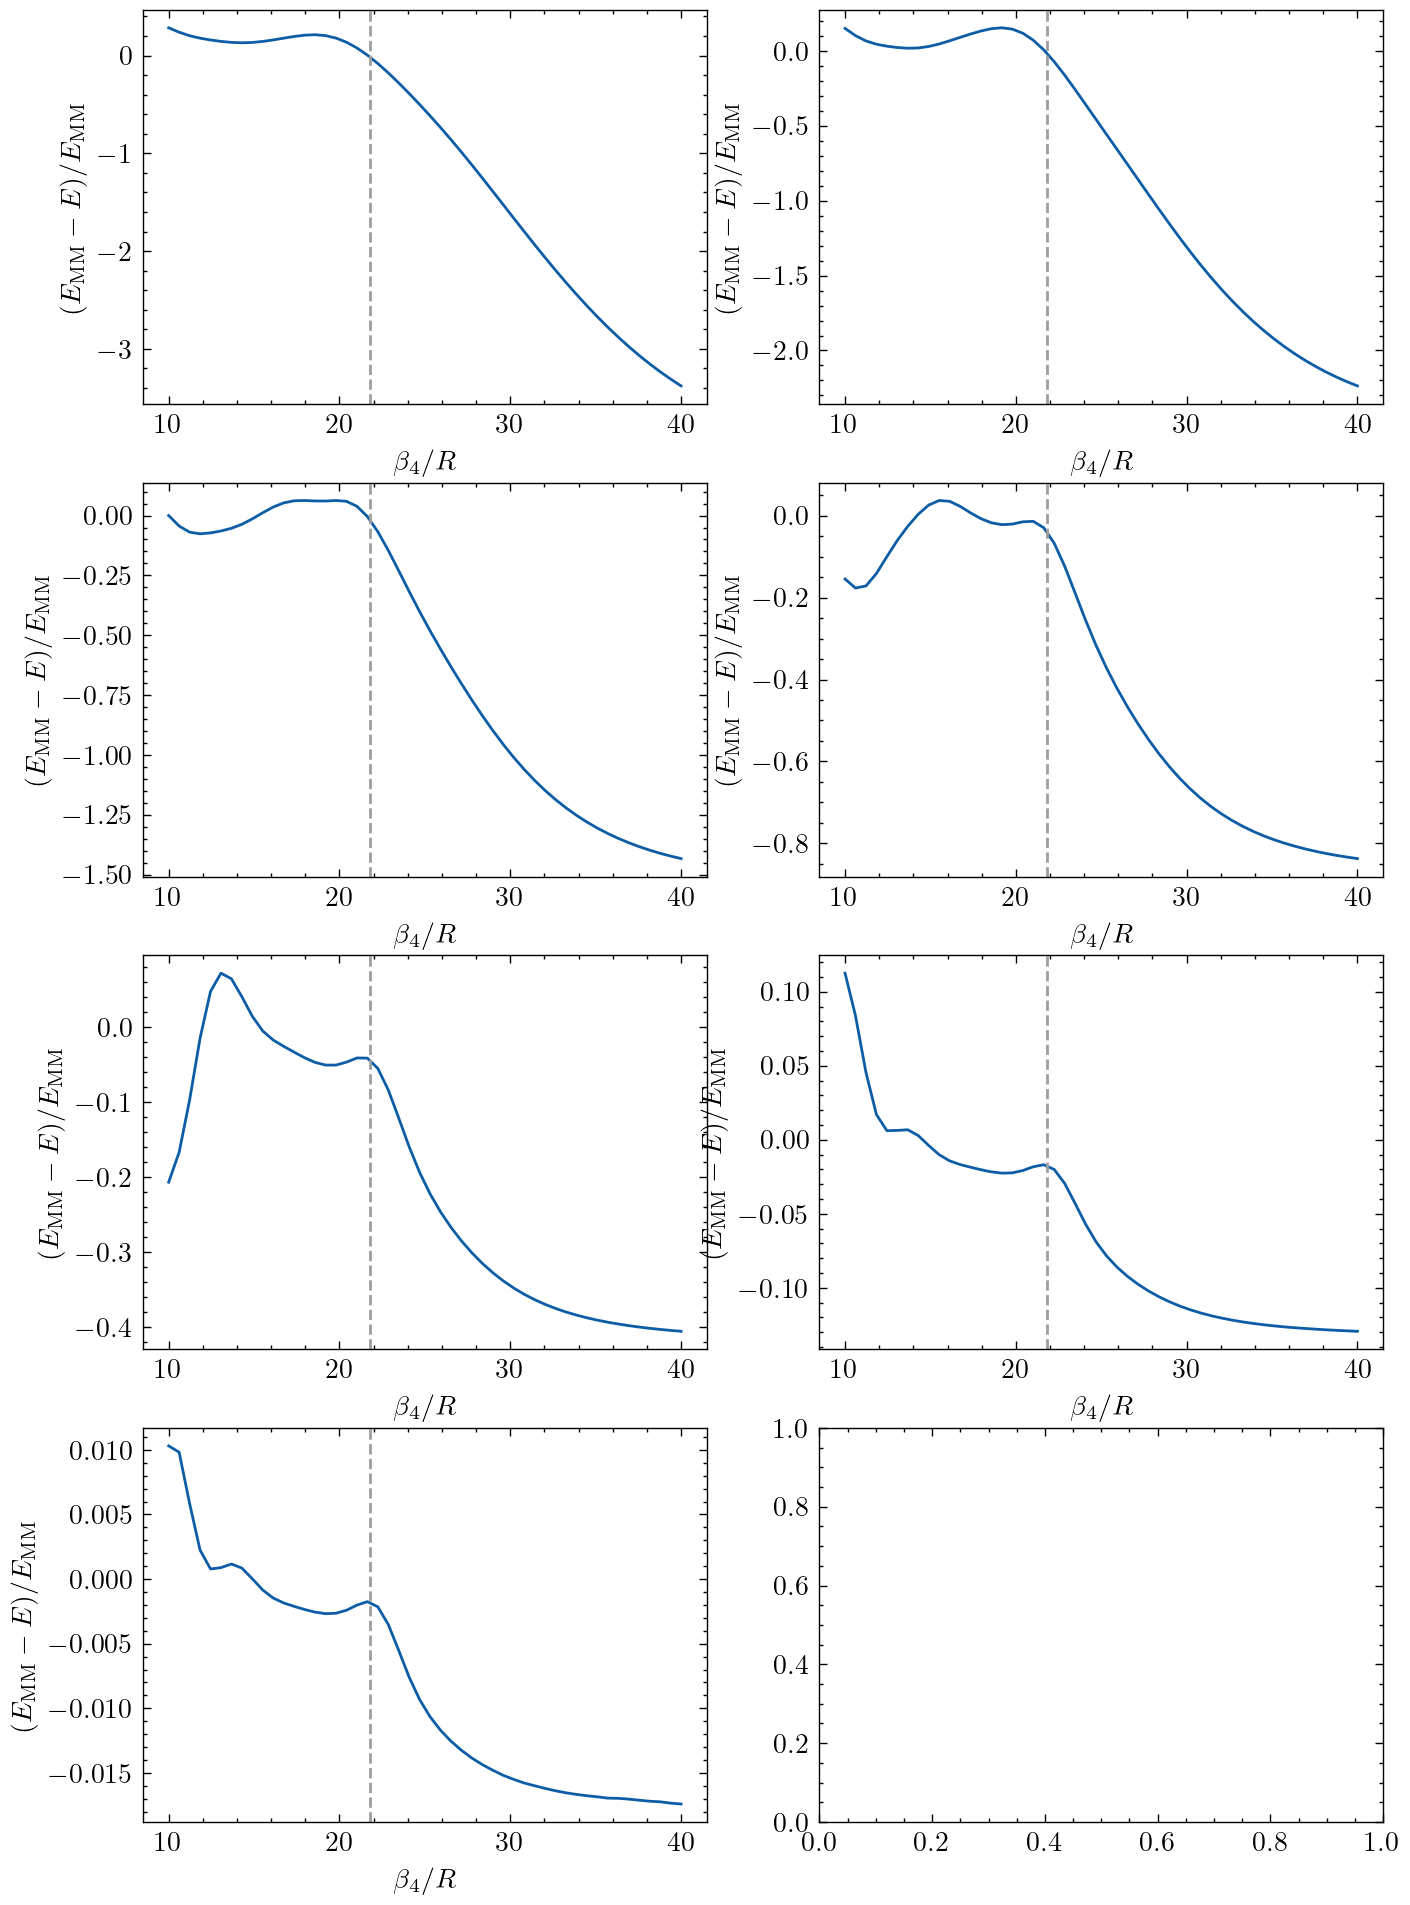

In [24]:
fig, ax = plt.subplots(4, 2, figsize=(2*gr*h, 4*h), dpi=200)
fig.patch.set_facecolor('white')

for i in range(7):
    ax[i//2, i%2].plot(const.BETA4/Rs, (mm_evals[i] - lo_specs[:, i])/mm_evals[i])
    ax[i//2, i%2].set_xlabel(r'$\beta_4/R$')
    ax[i//2, i%2].set_ylabel(r'$(E_{\rm MM}-E)/E_{\rm MM}$')
    ax[i//2, i%2].axvline(const.BETA4/1.5, linestyle='--', color='C6')

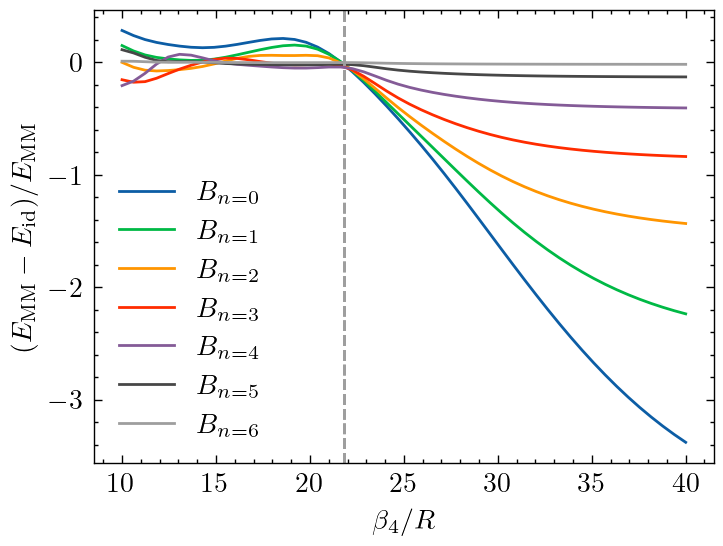

In [25]:
fig, ax = plt.subplots(figsize=(gr*h, h), dpi=200)
fig.patch.set_facecolor('white')

for i in range(7):
    ax.plot(const.BETA4/Rs, (mm_evals[i] - lo_specs[:, i])/mm_evals[i], label='$B_{n=%d}$' % (i))
    ax.set_xlabel(r'$\beta_4/R$')
    ax.set_ylabel(r'$(E_{\rm MM}-E_{\rm id})/E_{\rm MM}$')
    ax.axvline(const.BETA4/1.5, linestyle='--', color='C6')
ax.legend();

In [26]:
np.savetxt('rgflow_local_lo_a0_fix.txt', np.vstack((Rs, glos)).T, header='R  g_LO')

In [27]:
np.savetxt('spectra_local_lo_a0_fix.txt', np.vstack((Rs, lo_specs.T)).T,
           header ='R  E_0  E_1  E_2  E_3  E_4  E_5  E_6')

In [29]:
rgflow_nlo = np.loadtxt('rgflow_local_nlo_a0_B6_fix.txt')

In [31]:
(glos - rgflow_nlo[:, 1]) / glos

array([-1.04916403e-05, -1.16601823e-05, -1.35075608e-05, -1.49635456e-05,
       -1.53739557e-05, -1.53263208e-05, -1.56102040e-05, -1.64873546e-05,
       -1.77934145e-05, -1.92133302e-05, -2.05926577e-05, -2.20504769e-05,
       -2.38106611e-05, -2.60354679e-05, -2.88296818e-05, -3.23159071e-05,
       -3.66816810e-05, -4.22607770e-05, -5.01419196e-05, -6.44038229e-05,
       -1.00961158e-04, -2.91746335e-04,  3.55595446e-04,  1.24649772e-04,
        8.20948256e-05,  6.42600658e-05,  5.46341376e-05,  4.90100324e-05,
        4.57911741e-05,  4.42010500e-05,  4.38034824e-05,  4.43223940e-05,
        4.55750397e-05,  4.74351283e-05,  4.98068702e-05,  5.26238370e-05,
        5.58377578e-05,  5.94139537e-05,  6.33246673e-05,  6.75640837e-05,
        7.21152976e-05,  7.69665761e-05,  8.21285347e-05,  8.75936012e-05,
        9.33629961e-05,  9.94304849e-05,  1.05812331e-04,  1.12516602e-04,
        1.19526663e-04,  1.26857526e-04])